# QuTiP Example: The Transfer Tensor Method for Non-Markovian Open Quantum Systems

[Arne L. Grimsmo](http://arnegrimsmo.weebly.com/) <br>
Université de Sherbrooke <br>
[arne.grimsmo@gmail.com](email:arne.grimsmo@gmail.com)
$\newcommand{\ket}[1]{\left|#1\right\rangle}$
$\newcommand{\bra}[1]{\left\langle#1\right|}$

## Introduction

The "Transfer Tensor Method" was introduced by Cerrillo and Cao in [Phys. Rev. Lett 112, 110401 (2014)](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.112.110401) ([arXiv link](http://arxiv.org/abs/1307.7743)), as a general method for evolving non-Markovian open quantum systems.

The method takes as input a set of dynamical maps $\mathcal{E}_k$, such that

$$
\rho(t_k) = \mathcal{E}_k \rho(0)
$$

for an intial set of times $t_k$. This set of dynamical maps could be the result of experimental process tomography of they could be precomputed through some other (typically costly) method. The idea is that based on knowledge of these maps, one can try to exptrapolate the, in general non-Markovian, time-evolution to larger times, $t_n > t_k$. The method assumes that there is no explicit time-dependence in the total system-bath Hamiltonian.

## Preamble

### Imports

In [1]:
import numpy as np

import qutip as qt
from qutip.ipynbtools import version_table

import qutip.nonmarkov.transfertensor as ttm

### Plotting Support

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Jaynes-Cummings model, with the cavity as a non-Markovian bath

As a simple example, we consider the Jaynes-Cummings mode, and the non-Markovian dynamics of the qubit when the cavity is traced out. In this example, the dynamical maps $\mathcal{E}_k$ are the reduced time-propagators for the qubit, after evolving and tracing out the cavity, i.e.

$$
\mathcal{E}_k \rho = {\rm tr}_{\rm cav} \left[ {\rm e}^{\mathcal{L} t_k} \rho \otimes \rho_{0,{\rm cav}} \right],
$$

where $\mathcal{L}$ is the Lindbladian for the dissipative JC model (defined below) and $\rho_{0,{\rm cav}}$ is the initial state of the cavity.

## Problem setup

In [6]:
kappa = 1.0 # cavity decay rate
wc = 0.0*kappa # cavity frequency
wa = 0.0*kappa # qubit frequency
g = 10.0*kappa # coupling strength
N = 3 # size of cavity basis

# intial state
psi0c = qt.basis(N,0)
rho0c = qt.ket2dm(psi0c)
rho0a = qt.ket2dm(qt.basis(2,0))
rho0 = qt.tensor(rho0a,rho0c)
rho0avec = qt.operator_to_vector(rho0a)

# identity superoperator
Id = qt.tensor(qt.qeye(2),qt.qeye(N))
E0 = qt.sprepost(Id,Id)

# partial trace over the cavity, reprsented as a superoperator
ptracesuper = qt.tensor_contract(E0,(1,3))

# intial state of the cavity, represented as a superoperator
superrho0cav = qt.sprepost(qt.tensor(qt.qeye(2),psi0c),
                           qt.tensor(qt.qeye(2),psi0c.dag()))

# operators
a  = qt.tensor(qt.qeye(2), qt.destroy(N))
sm = qt.tensor(qt.sigmam(), qt.qeye(N))
sz = qt.tensor(qt.sigmaz(), qt.qeye(N))

# Hamiltonian
H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())
c_ops = [np.sqrt(kappa)*a]

## Exact timepropagators to learn from

The function `dynmap` generates an exact timepropagator for the qubit $\mathcal{E}_{k}$ for a time $t_k$. <br>

In [7]:
def dynmap(t):
    # reduced dynamical map for the qubit at time t
    Et = qt.mesolve(H, E0, [0.,t], c_ops, []).states[-1]
    return ptracesuper*(Et*superrho0cav)

## Exact time evolution using standard mesolve method

In [8]:
exacttimes = np.arange(0,5,0.01)
exactsol = qt.mesolve(H, rho0, exacttimes, c_ops, [])

## Approximate solution using the Transfer Tensor Method for different learning times

In [9]:
times = np.arange(0,5,0.1) # total extrapolation time
ttmsols = []
maxlearningtimes = [0.5, 2.0] # maximal learning times
for T in maxlearningtimes:
    learningtimes = np.arange(0,T,0.1)
    learningmaps = [dynmap(t) for t in learningtimes] # generate exact dynamical maps to learn from
    ttmsols.append(ttm.ttmsolve(learningmaps, rho0a, times)) # extrapolate using TTM

## Visualize results

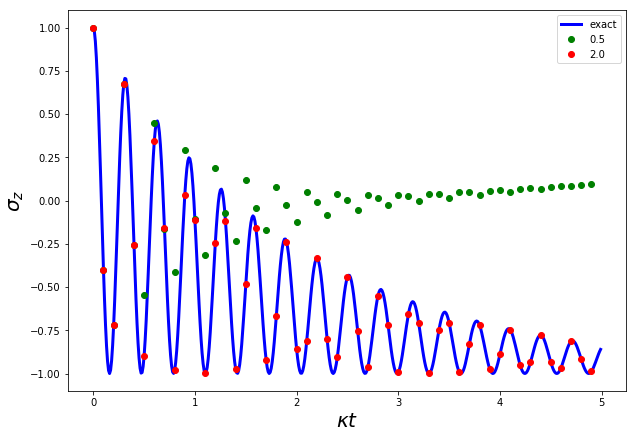

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(exactsol.times, qt.expect(sz, exactsol.states),'-b',linewidth=3.0)
style = ['og','or']
for i,ttmsol in enumerate(ttmsols):
    ax.plot(ttmsol.times, qt.expect(qt.sigmaz(), ttmsol.states),style[i],linewidth=1.5,)
ax.legend(['exact',str(maxlearningtimes[0]),str(maxlearningtimes[1])])
ax.set_xlabel(r'$\kappa t$', fontsize=20)
ax.set_ylabel(r'$\sigma_z$', fontsize=20)

# Discussion

The figure above illustrates how the transfer tensor method needs a sufficiently long set of learning times to get good results. The green dots show results for learning times $t_k=0,0.1,\dots,0.5$, which is clearly not sufficient. The red dots show results for $t_k=0,0.1,\dots,2.0$, which gives results that are in very good agreement with the exact solution.

## Epilouge

In [11]:
version_table()

Software,Version
QuTiP,4.2.0
Numpy,1.13.1
SciPy,0.19.1
matplotlib,2.0.2
Cython,0.25.2
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,6.1.0
Python,"3.6.1 |Anaconda custom (x86_64)| (default, May 11 2017, 13:04:09) [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]"
OS,posix [darwin]
